<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [16]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Reading original data

In [3]:
PATH_TO_DATA = ('../../data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [5]:
import pickle

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')


# Load websites dictionary
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
12424,apps.geofluent.com
12582,cdsonline.blog.lemonde.fr
45245,fr.static.bata.eu
4927,dbd.linternaute.com
2088,js1.closermag.fr


Separate target feature 

In [6]:
y = train_df['target']

In [7]:
train_sites = train_df[sites].values.flatten()
test_sites = test_df[sites].values.flatten()
good_sites = train_df[y == 0][sites].values.flatten()
bad_sites = train_df[y == 1][sites].values.flatten()

unique_train_sites = set(train_sites)
unique_test_sites = set(test_sites)
unique_good_sites = set(good_sites)
unique_bad_sites = set(bad_sites)

In [8]:
full_df = pd.concat([train_df.drop('target', axis=1), test_df], ignore_index=True)
sites_full = full_df[sites]
train_indices = sites_full.index[:len(train_df)]
test_indices = sites_full.index[len(train_df):]

In [9]:
for site_id in sites:
    print(" . ", end='')
    sites_full[site_id] = sites_full[site_id].apply(lambda x: sites_dict['site'][x] + " " if x > 0 else "")

 .  .  .  .  .  .  .  .  .  . 

In [10]:
sites_full_aligned = sites_full.loc[:, :].sum(axis=1)
sites_full_aligned = sites_full_aligned.apply(lambda x: x[:-1])

In [11]:
sites_full_aligned.head()

0    safebrowsing.clients.google.com safebrowsing-c...
1    safebrowsing.clients.google.com safebrowsing-c...
2    www.apache.org www.apache.org download.eclipse...
3    www.webtide.com download.oracle.com www.caucho...
4    public.dhe.ibm.com jope.ow2.org download.oracl...
dtype: object

In [12]:
train_y1_indices = np.where(np.isin(train_df.index.values, train_df[y == 1].index.values))[0]

In [13]:
train_y1_indices[0]

3568

In [14]:
sites_full_aligned = sites_full_aligned.str.replace('.com', '').str.replace('www.', '')

In [15]:
sites_full_aligned[train_y1_indices[:5]].values

array(['api.bing api.bing api.bing google.fr google.fr info-jeunes.net google.fr info-jeunes.net platform.twitter info-jeunes.net',
       'facebook info-jeunes.net twitter info-jeunes.net info-jeunes.net facebook info-jeunes.net facebook info-jeunes.net info-jeunes.net',
       'facebook info-jeunes.net info-jeunes.net facebook twitter info-jeunes.net facebook info-jeunes.net facebook api.bing',
       'bing bing leboncoin.fr bing twitter static.leboncoin.fr deliv.leboncoin.fr leboncoin.fr deliv.leboncoin.fr static.leboncoin.fr',
       '193.164.196.50pteperso.leboncoin.frpteperso.leboncoin.fr leboncoin.fr leboncoin.fr 193.164.197.60 static.leboncoin.fr leboncoin.fr 193.164.196.50 193.164.197.40'],
      dtype=object)

## Create features

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [17]:
vectorizer = CountVectorizer(max_features=1500000, ngram_range=(1, 3))
vectorizer.fit(sites_full_aligned)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1500000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
len(vectorizer.vocabulary_)

779358

In [19]:
train_sites_cvec = vectorizer.transform(sites_full_aligned[train_indices])
test_sites_cvec = vectorizer.transform(sites_full_aligned[test_indices])

In [20]:
vectorizer.get_feature_names()

['00',
 '00 art',
 '00 art skyrock',
 '00 delcampe',
 '00 delcampe static',
 '00148c1e65687476',
 '00148c1e65687476 users',
 '00148c1e65687476 users storage',
 '00265',
 '00265 ora',
 '00265 ora code',
 '006',
 '006 free',
 '006 free counters',
 '007',
 '007 007',
 '007 007 007',
 '007 007 login',
 '007 google',
 '007 google 007',
 '007 ie7',
 '007 ie7 js',
 '007 login',
 '007 login wikimedia',
 '009',
 '009 mktoresp',
 '009 mktoresp 625',
 '009 mktoresp bing',
 '009 mktoresp blog',
 '009 mktoresp code',
 '009 mktoresp download',
 '009 mktoresp forum',
 '009 mktoresp google',
 '009 mktoresp gravatar',
 '009 mktoresp gtssl',
 '009 mktoresp mail',
 '009 mktoresp ocsp',
 '009 mktoresp play',
 '009 mktoresp plus',
 '009 mktoresp spring',
 '009 mktoresp stackauth',
 '009 mktoresp stackoverflow',
 '009 mktoresp uaa',
 '009 rur',
 '009 rur 657',
 '00oo00',
 '00oo00 pos',
 '00oo00 pos baidu',
 '01',
 '01 10005',
 '01 10005 101304103',
 '01 10005 101990267',
 '01 10005 102048726',
 '01 10005 10

tf-idf of a site URL in sessions:

TfIdf from site id:

In [20]:
def add_custom_tfidf(df):
    for site_id in sites:
        df.loc[:, 'tf_%s' % site_id] = 0
        df.loc[:, 'tf_%s' % site_id] = np.log(1.0 + df.loc[:, sites].eq(df.loc[:, site_id], axis=0).sum(axis=1))

    N = len(df)
    for site_id in sites:
        df.loc[:, 'idf_%s' % site_id] = 0
        site_id_idf = np.log(1 + N / (1 + df[site_id].value_counts()))
        df.loc[:, 'idf_%s' % site_id] = df.loc[:, site_id].apply(lambda x: site_id_idf[x])

    for site_id in sites:
        df.loc[:, 'tfidf_%s' % site_id] = df.loc[:, 'tf_%s' % site_id] * df.loc[:, 'idf_%s' % site_id]


Add features based on the session start time: hour, whether it's morning, day or night and so on.

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.sparse import hstack

def to_daytime(hour):
    if 7 <= hour < 9:
        return 0
    elif 9 <= hour < 11:
        return 1
    elif 11 <= hour < 14:
        return 2
    elif 14 <= hour < 17:
        return 3
    elif 17 <= hour < 20:
        return 4
    elif 20 <= hour < 24:
        return 5
    elif 0 <= hour < 4:
        return 6
    elif 4 <= hour < 7:
        return 7
    else:
        return -1


def is_not_weekend(weekday):
    return 0 if 5 <= weekday <= 6 else 1

def is_saturday(weekday):
    return 1 if 5 == weekday else 0

def is_sunday(weekday):
    return 1 if 6 == weekday else 0

    
def compute_timebased_features(df, scaler=None, ohe=None):
    df = df.copy()
    times = ['time%s' % i for i in range(1, 11)]
    for time_id in times:
        df[time_id] = pd.to_datetime(df[time_id])

#     df.loc[:, 'daytime1'] = df.loc[:, 'time1'].apply(lambda x: to_daytime(x.hour))
#     res1 = pd.get_dummies(df['daytime1'], prefix='daytime')
#     res1['daytime_0'] = ~res1['daytime_0']
#     res1['daytime_1'] = ~res1['daytime_1']
#     res1['daytime_5'] = ~res1['daytime_5']
#     del res1['daytime_2']

    df.loc[:, 'yearmonth1'] = df.loc[:, 'time1'].apply(lambda x: -(x.year * 100 + x.month) / 201500.0)
    df.loc[:, 'yearmonth2'] = df.loc[:, 'time1'].apply(lambda x: -(x.year * 100 + x.month) / 201500.0 + 0.5)

    df.loc[:, 'h'] = df.loc[:, 'time1'].apply(lambda x: x.hour)
    res2 = pd.get_dummies(df['h'], prefix='h')
    res2 = ~res2
    res2['h_12'] = ~res2['h_12']
    res2['h_16'] = ~res2['h_16']
    del res2['h_13']
    del res2['h_17']
    del res2['h_18']
    del res2['h_19']
    del res2['h_20']
    del res2['h_21']
    del res2['h_22']
    del res2['h_23']

    df.loc[:, 'hm'] = df.loc[:, 'time1'].apply(lambda x: (x.hour * 100 + x.minute) / 2400.0)

    df.loc[:, 'wd'] = df.loc[:, 'time1'].apply(lambda x: x.weekday())
    res3 = pd.get_dummies(df['wd'], prefix='wd')
    del res3['wd_1']
    del res3['wd_3']
    del res3['wd_4']
    res3['wd_2'] = ~res3['wd_2']
    res3['wd_5'] = ~res3['wd_5']
    res3['wd_6'] = ~res3['wd_6']

    df.loc[:, 'start_hour'] = df['time1'].apply(lambda x: x.hour)
    df.loc[:, 'start_month'] = df['time1'].apply(lambda x: x.month)

    df.loc[:, 'is_not_weekend'] = df.loc[:, 'time1'].apply(lambda x: is_not_weekend(x.weekday()))
    df.loc[:, 'is_not_saturday'] = df.loc[:, 'time1'].apply(lambda x: ~is_saturday(x.weekday()))
    df.loc[:, 'is_not_sunday'] = df.loc[:, 'time1'].apply(lambda x: ~is_sunday(x.weekday()))

    df.loc[:, 'session_duration'] = (df.loc[:, 'time10'] - df.loc[:, 'time1']).apply(lambda x: -x.seconds / 3600.0)
    df['session_duration'].fillna(0, inplace=True)
    features = ['session_duration', 'is_not_saturday',
                'is_not_sunday', 'hm', 'yearmonth1', 'yearmonth2',
                'start_hour', 'start_month']
#     return pd.concat([df[features], res1, res2, res3], axis=1)
    return pd.concat([df[features], res2, res3], axis=1)  


def add_timebased_features(X, df):
    df = compute_timebased_features(df)
    X = hstack([X, df])
    return X


In [33]:
# times = ['time%s' % i for i in range(1, 11)]
# for time_id in times:
#     train_df[time_id] = pd.to_datetime(train_df[time_id])

# train_df.loc[:, 'session_duration'] = (train_df['time10'] - train_df['time1']).apply(lambda x: x.seconds)

# train_df[y == 1]['session_duration'].describe()

# train_df[y == 0]['session_duration'].describe()

# features = ['ndaytime%s' % i for i in range(1, 11)] + ['session_duration', ]    

# daytimes = compute_timebased_features(train_df)

In [62]:
# bad_daytimes = np.bincount((6 * daytimes[y == 1].values.flatten()).astype(int))
# good_daytimes = np.bincount((6 * daytimes[y == 0].values.flatten()).astype(int))

In [57]:
# X = add_timebased_features(train_sites_tfidf, train_df)
# X = train_sites_tfidf
# X = compute_timebased_features(train_df)
# X.shape

In [36]:
X = compute_timebased_features(train_df)
X.shape

(253561, 21)

In [37]:
X.corrwith(y)

session_duration    0.024471
is_not_saturday     0.017586
is_not_sunday       0.016251
hm                  0.095489
yearmonth1          0.034096
yearmonth2          0.034096
start_hour          0.095180
start_month         0.035521
h_7                 0.003509
h_8                 0.031880
h_9                 0.031388
h_10                0.037418
h_11                0.035169
h_12                0.029982
h_14                0.032679
h_15                0.023247
h_16                0.112847
wd_0                0.057825
wd_2                0.047074
wd_5                0.017586
wd_6                0.016251
dtype: float64

In [ ]:
X.corr()

In [65]:
X.head()

,session_duration,is_not_saturday,is_not_sunday,hm,yearmonth,start_hour,start_month,daytime_0,daytime_1,daytime_3,...,h_10,h_11,h_12,h_14,h_15,h_16,wd_0,wd_2,wd_5,wd_6
session_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,-1,-1,0.417500,-0.999514,10,2,255,254,0,...,254,255,0,255,255,0,0,255,255,255
2,-0.007222,-2,-1,0.466250,-0.999514,11,2,255,255,0,...,255,254,0,255,255,0,0,255,254,255
3,-0.001944,-1,-1,0.683333,-0.999067,16,12,255,255,1,...,255,255,0,255,255,1,1,255,255,255
4,-0.075000,-1,-1,0.438333,-0.999519,10,3,255,254,0,...,254,255,0,255,255,0,0,255,255,255
5,-0.068333,-1,-1,0.438750,-0.999514,10,2,255,254,0,...,254,255,0,255,255,0,0,255,255,255


In [66]:
from sklearn.feature_selection import SelectFromModel

log_reg = LogisticRegression(penalty='l2')
log_reg.fit(X, y)
model = SelectFromModel(log_reg, prefit=True)
X_new = model.transform(X)
X_new.shape

(253561, 10)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
clf.feature_importances_

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

Perform cross-validation with logistic regression.

In [60]:
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [87]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42)

log_reg_cv = LogisticRegressionCV(cv=skf, scoring='roc_auc',
                                  random_state=42, verbose=True, n_jobs=-1)

# class_weight = {
#     0: 1,
#     1: 15
# }
# log_reg_cv = LogisticRegressionCV(cv=skf, class_weight=class_weight, scoring='roc_auc', 
#                                   random_state=42, verbose=True, n_jobs=-1)

# log_reg_cv = LogisticRegressionCV(cv=skf, class_weight='balanced', scoring='roc_auc', 
#                                   random_state=42, verbose=True, n_jobs=-1)

In [88]:
log_reg_cv.fit(X_new, y)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.0s finished


LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=42, refit=True, scoring='roc_auc', solver='lbfgs',
           tol=0.0001, verbose=True)

In [89]:
np.mean(log_reg_cv.scores_[1], axis=0), log_reg_cv.C_

(array([0.83467914, 0.83593491, 0.84896108, 0.89226353, 0.94267458,
        0.96891551, 0.97468549, 0.97292993, 0.96470182, 0.96579021]),
 array([21.5443469]))

In [90]:
from sklearn.metrics import roc_auc_score, recall_score

y_pred = log_reg_cv.predict(X_new)

In [91]:
y_probas = log_reg_cv.predict_proba(X_new)

In [92]:
y_probas[:10, 1]

array([5.48116725e-06, 1.97824596e-02, 2.42200705e-04, 4.09600151e-06,
       1.41577619e-04, 3.36121552e-08, 1.09464371e-03, 5.00338562e-06,
       1.39643704e-02, 6.09211036e-04])

In [93]:
from sklearn.metrics import confusion_matrix

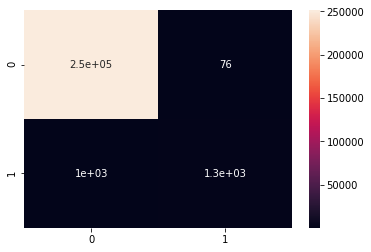

In [94]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

In [95]:
m

array([[251188,     76],
       [  1032,   1265]])

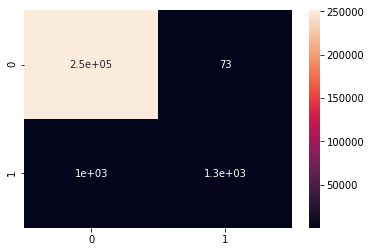

In [50]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

max_features=5000000, ngram_range=(1, 4) + ndaytimes + session duration

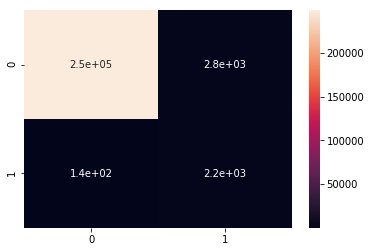

In [34]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

max_features=5000000, ngram_range=(1, 4)

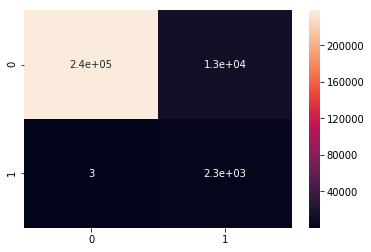

In [30]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

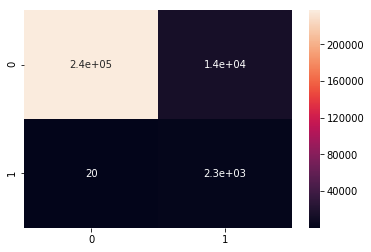

In [37]:
m = confusion_matrix(y, y_pred)
sns.heatmap(m, annot=True)

**Results:**

457510 tf-idf ngrams=(1,3) default tokenizer
```
(array([0.87793424, 0.89270005, 0.93151662, 0.96033089, 0.97152704,
        0.97398161, 0.97245746, 0.96887418, 0.96895329, 0.96782162]),
 array([2.7825594]))
 ```

378190 tfidf features ngrams=(1, 2)

`(array([0.88413484, 0.89676234, 0.92163549, 0.94630596, 0.95751679,
        0.95765139, 0.94786301, 0.93324887, 0.91174217, 0.91658067]),
 array([2.7825594]))`

100 tfidf site features

`array([0.84036089, 0.86739761, 0.88847426, 0.89525702, 0.89740772,
       0.89863011, 0.89907569, 0.89975907, 0.8995833 , 0.89978664])`

Site index custom tfidfs + ndaytimes

```
(array([0.761606  , 0.76186965, 0.76305951, 0.76328609, 0.76290517,
        0.76260131, 0.76257309, 0.7625813 , 0.76258039, 0.76259375]),
 array([0.04641589]))
```

Make prediction for the test set and form a submission file.

In [35]:
X_test = add_timebased_features(test_sites_tfidf, test_df)

In [36]:
X_test.shape

(82797, 779368)

In [39]:
test_probas = log_reg_cv.predict_proba(X_test)
test_probas = test_probas[:, 1]
test_probas

array([4.69388715e-04, 1.25089673e-05, 8.80408282e-07, ...,
       1.58690979e-03, 1.59689548e-06, 1.68119845e-05])

In [42]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [43]:
write_to_submission_file(test_probas, "assignment6_alice_submission_FN=1027_FP=73.csv")

In [45]:
!tail assignment6_alice_submission_FN=1027_FP=73.csv

82788,0.0003164514741985948
82789,0.002434915919476452
82790,6.914197934015894e-05
82791,0.00017464404714817965
82792,7.32944357517232e-05
82793,3.4937872820058705e-07
82794,1.5915246155362633e-05
82795,0.0015869097910923909
82796,1.5968954822344062e-06
82797,1.68119844891701e-05


In [280]:
!tail assignment6_alice_submission2.csv

82788,0
82789,0
82790,0
82791,0
82792,0
82793,0
82794,0
82795,0
82796,0
82797,0
